In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import zipfile
from PIL import Image
from numpy import array
from keras.utils import to_categorical

In [11]:
img_width, img_height = 16, 16
batch_size = 150
no_epochs = 50
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0
# noise_factor = 0.1
# noise_factor = 0.4
noise_factor = 0.8
number_of_visualizations = 6
local_zip = '/content/USPS_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/trainntest')
train_dir = '/content/trainntest/USPS_images/train'
validation_dir = '/content/trainntest/USPS_images/test'
y_train = []
y_test = []
x_train = []
x_test = []
for path in os.listdir(train_dir):
    if os.path.isfile(os.path.join(train_dir, path)):
        y_train.append(int(path[0]))

for path in os.listdir(validation_dir):
  if os.path.isfile(os.path.join(validation_dir, path)):
      y_test.append(int(path[0]))


for path in os.listdir(train_dir):
  if os.path.isfile(os.path.join(train_dir,path)):
    x_train.append(cv2.cvtColor(cv2.imread(f"{train_dir}/{path}"), cv2.COLOR_RGB2GRAY))

for path in os.listdir(validation_dir):
  if os.path.isfile(os.path.join(validation_dir,path)):
    x_test.append(cv2.cvtColor(cv2.imread(f"{validation_dir}/{path}"), cv2.COLOR_RGB2GRAY))



input_train = np.array(x_train)
input_test = np.array(x_test)


target_train = to_categorical(y_train, 10)
target_test = to_categorical(y_test, 10)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 32)        18464     
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 32)       9248      
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 64)       18496     
 ranspose)                                                       
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 1)         577       
                                                                 
Total params: 47,425
Trainable params: 47,425
Non-trai

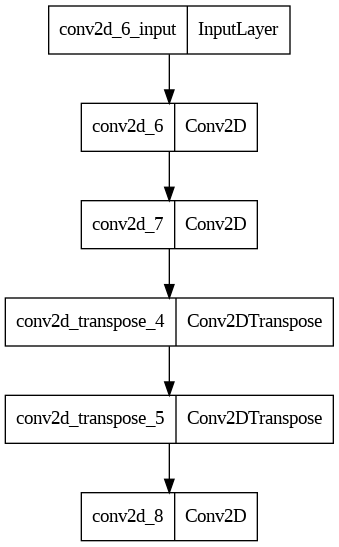

In [12]:

# Reshape data based on channels first / channels last strategy.
# This is dependent on whether you use TF, Theano or CNTK as backend.
# Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
if K.image_data_format() == 'channels_first':
    input_train = input_train.reshape(input_train.shape[0], 1, img_width, img_height)
    input_test = input_test.reshape(input_test.shape[0], 1, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    input_train = input_train.reshape(input_train.shape[0], img_width, img_height, 1)
    input_test = input_test.reshape(input_test.shape[0], img_width, img_height, 1)
    input_shape = (img_width, img_height, 1)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

# Add noise
pure = input_train
pure_test = input_test
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

# Create the model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2DTranspose(32, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2DTranspose(64, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(1, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

model.summary()
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png')

# Compile and fit data


1/1 [==============================] - 0s 148ms/step


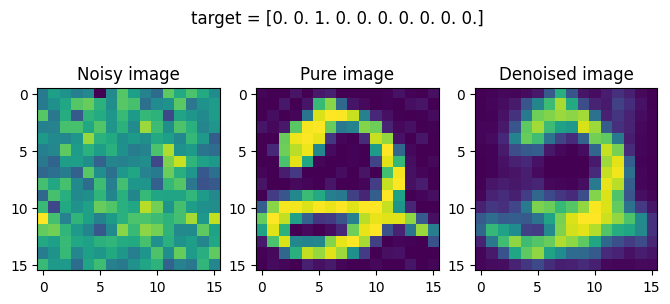

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(noisy_input, pure,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                verbose=0)

# Generate denoised images
samples = noisy_input_test[:1]
targets = target_test[:1]
denoised_images = model.predict(samples)

# Plot denoised images

# Get the sample and the reconstruction
noisy_image = noisy_input_test[0][:, :, 0]
pure_image  = pure_test[0][:, :, 0]
denoised_image = denoised_images[0][:, :, 0]
input_class = targets[0]
tg = 0
for i in range(10):
    if input_class[i] == 1:
        tg = i
# Matplotlib preparations
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(8, 3.5)
# Plot sample and reconstruciton
axes[0].imshow(noisy_image)
axes[0].set_title('Noisy image')
axes[1].imshow(pure_image)
axes[1].set_title('Pure image')
axes[2].imshow(denoised_image)
axes[2].set_title('Denoised image')
fig.suptitle(f'target = {tg}')
plt.show()